In [1]:
import torch
import numpy as np
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pathlib
from pathlib import Path


In [2]:
n_samples = 1000
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [3]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [4]:
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})
print(circles.head(10))

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0


In [5]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

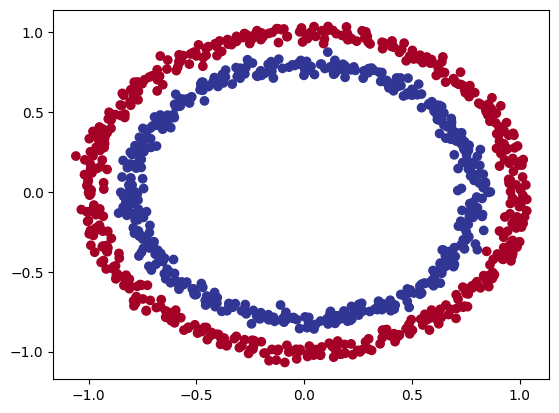

In [6]:
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: tensor([0.7542, 0.2315]) and the same for y: 1.0
Shapes for one sample of X: torch.Size([2]) and the same for y: torch.Size([])


In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device)

cpu


In [13]:
class CircleModelV0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = torch.nn.Linear(in_features = 2, out_features = 5)
        self.layer_2= torch.nn.Linear(in_features = 5, out_features = 1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

model_V0 = CircleModelV0().to(device)
model_V0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
untrained_preds = model_V0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.1875],
        [0.1644],
        [0.1904],
        [0.1869],
        [0.0989],
        [0.0855],
        [0.0929],
        [0.0742],
        [0.1943],
        [0.1618]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
loss_fn = torch.nn.BCEWithLogitsLoss() 

optimizer = torch.optim.SGD(params=model_V0.parameters(), 
                            lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

In [17]:
y_logits = model_V0(X_test.to(device))[:5]
y_logits

tensor([[0.1875],
        [0.1644],
        [0.1904],
        [0.1869],
        [0.0989]], grad_fn=<SliceBackward0>)

In [18]:
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.5467],
        [0.5410],
        [0.5475],
        [0.5466],
        [0.5247]], grad_fn=<SigmoidBackward0>)

In [19]:
y_preds = torch.round(y_preds_probs)
y_preds_labels = torch.round(torch.sigmoid(model_V0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [27]:
torch.manual_seed(42)

epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_V0.train()
    y_logits = model_V0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    optimizer.zero_grad()
    loss.backward()
    model_V0.eval()
    with torch.inference_mode():
        test_logits = model_V0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
        






Epoch: 0 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 10 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 20 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 30 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 40 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 50 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 60 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 70 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 80 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%
Epoch: 90 | Loss: 0.69613, Accuracy: 50.00% | Test loss: 0.69577, Test acc: 50.00%


In [28]:
if Path('helper_functions.py').is_file():
    print('File Already Exsists')
else:
    print('Downloading helper_funtions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py','wb') as f:
        f.write(request.content)


File Already Exsists


In [29]:
from helper_functions import plot_predictions, plot_decision_boundary

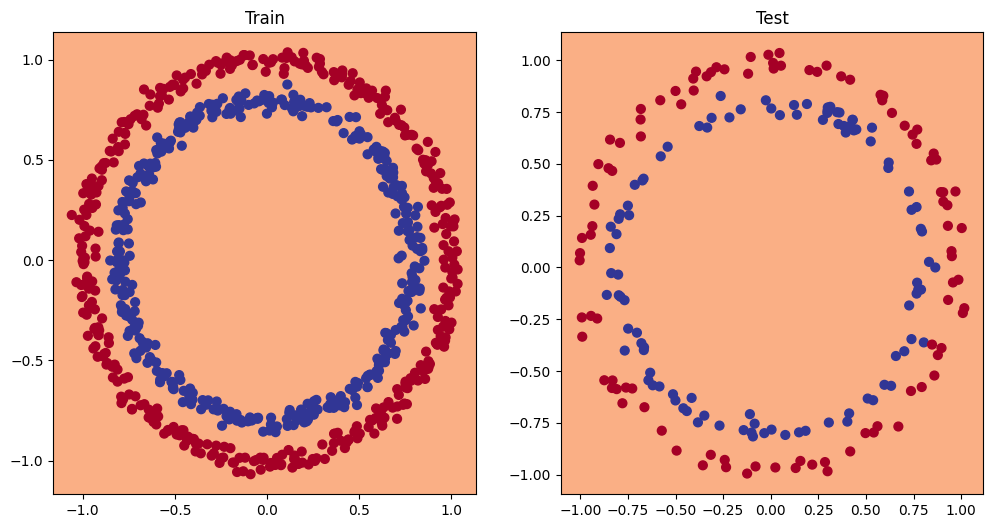

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_V0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_V0, X_test, y_test)

In [33]:
class CircleModelV1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = torch.nn.Linear(in_features=2, out_features=10)
        self.layer_2 = torch.nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = torch.nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): 
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_V1 = CircleModelV1().to(device)
model_V1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
torch.manual_seed(42)

epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_V1.train()
    y_logits = model_V1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    optimizer.zero_grad()
    loss.backward()
    model_V0.eval()
    with torch.inference_mode():
        test_logits = model_V1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 10 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 20 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 30 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 40 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 50 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 60 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 70 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 80 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 90 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 100 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epoch: 110 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 50.88%
Epo

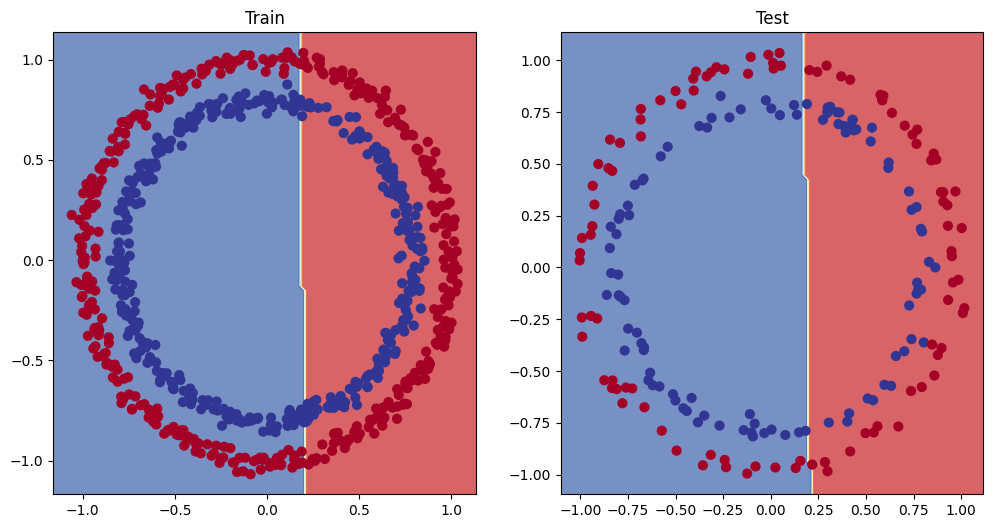

In [36]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_V1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_V1, X_test, y_test)

In [38]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() 

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [40]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [41]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [43]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

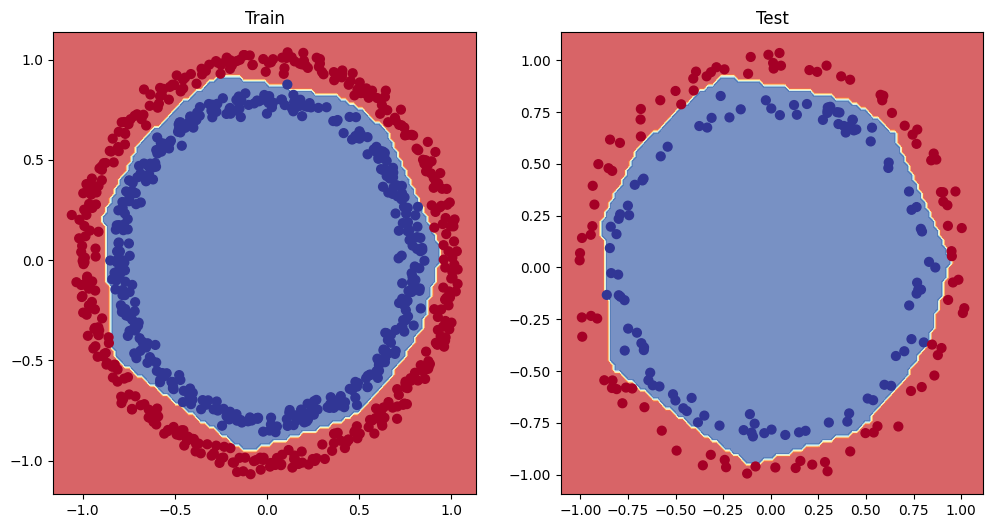

In [45]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity